In this notebook, I will work on a simple example of MCMC structure with Gaussian parameters. I will also examine the conjugate priors for Gaussian distributions. <br>

All this work will be conducted without the help of external MCMC libraries such as PyMC. <br>

Here, our goal is to approximate the mean of our normal distribution.

In [1]:
#Importing the libraries

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

sns.set_style('white')
sns.set_context('talk')

In [2]:
#Random sampling the data centered around zero from standard normal distribution.
data_mu = 0
data_sd = 1
data = st.norm.rvs(data_mu, data_sd, 100)

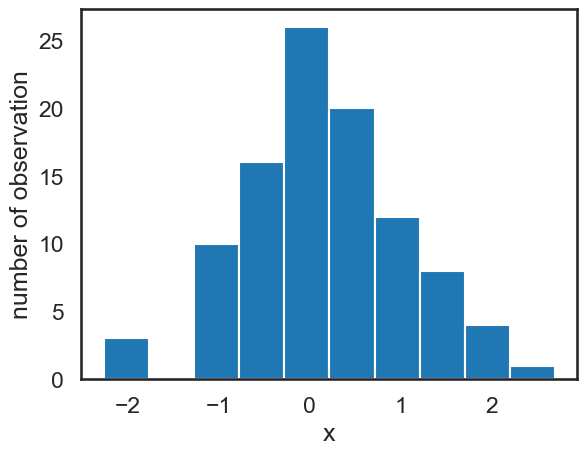

In [3]:
#Plotting the histogram of the data to see how the distribution looks like
plt.hist(data, bins=10)
plt.xlabel("x")
plt.ylabel("number of observation")
plt.show()


Here in this case, our likelihood is normal as the data is normally distributed. <br>

We also assume that our standard deviation ($\sigma$) is 1 and we want to infer the mean ($\mu$) parameter. <br>

For mean, we need to assume a prior as well. That, in this case, can be assumed to be sampled from a normal distribution with the mean of 0 and standard deviation of 1. <br>

For a likelihood model with given distribution, prior and posterior follows the same distribution. Therefore, we have a conjugate prior and conjugate posterior distribution. <br>

$\mu \sim Normal(0,1)$ and $ x|\mu \sim Normal(x; \mu,1)$

Since all of our distributions are Gaussian, we have a conjugate prior for Gaussian distribution which can be calculated analytically.

The logic is based on the paper/notes from Kevin P. Murphy [Conjugate Bayesian analysis of the Gaussian distribution](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf).

0.16686364019312133
0.00999900009999


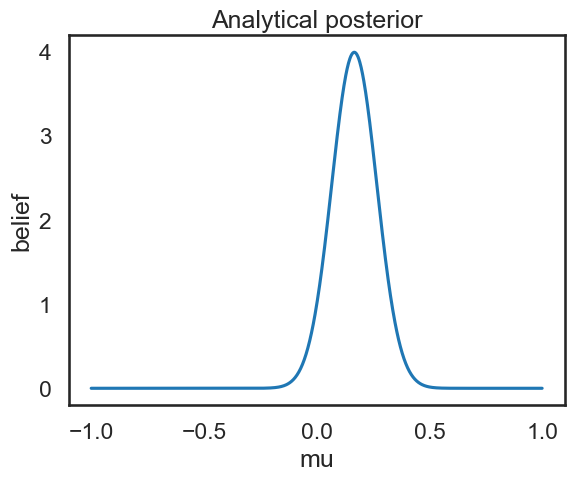

In [7]:
def gaussian_conjugate_posterior(data, x, mu_0, sigma_0):
    sigma = 1
    n = len(data)
    mu_posterior = (1/((1/sigma_0**2) + (n/sigma ** 2))) * ((mu_0/sigma_0**2) + (np.sum(data)/sigma ** 2))
    sigma_posterior = (1/((1/sigma_0**2) + (n/sigma ** 2)))
    print(mu_posterior)
    print(sigma_posterior)
    return st.norm(mu_posterior, np.sqrt(sigma_posterior)).pdf(x)

x = np.linspace(-1, 1, 1000)

posterior_calc = gaussian_conjugate_posterior(data, x, 0, 10)

plt.plot(x, posterior_calc)
plt.xlabel("mu")
plt.ylabel("belief")
plt.title("Analytical posterior")
plt.show()

Now, let's use MCMC approach to approximate posterior distribution. <br>

We will be using Metropolis algorithm.

[-0.003704443164480943, 0.07073026457837626, 0.016391340123957286, -0.05298290371263464, -0.1411977446038347, 0.23280566671073108, 0.21748793320806925, 0.15171312784270685, 0.2560822037903355]
0.1652280460961789
0.009900990099009901


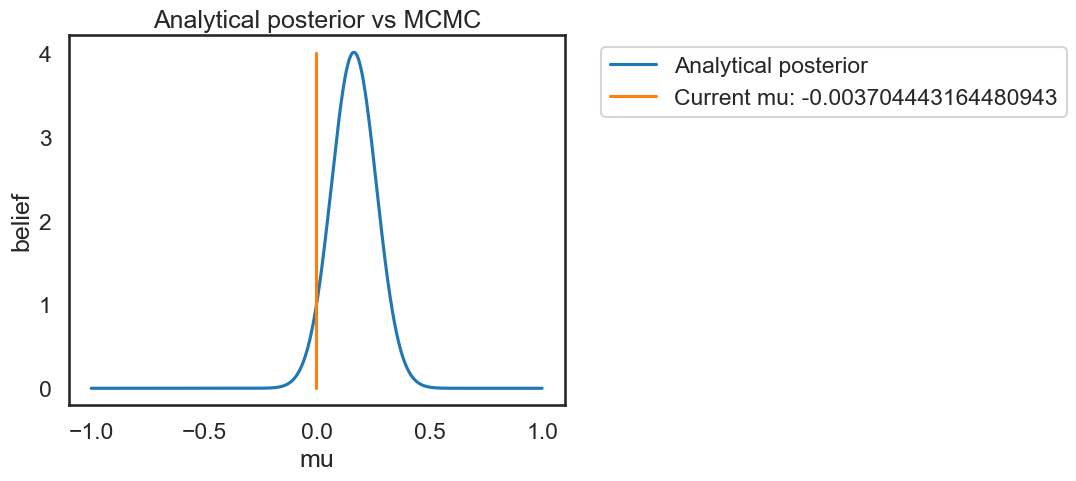

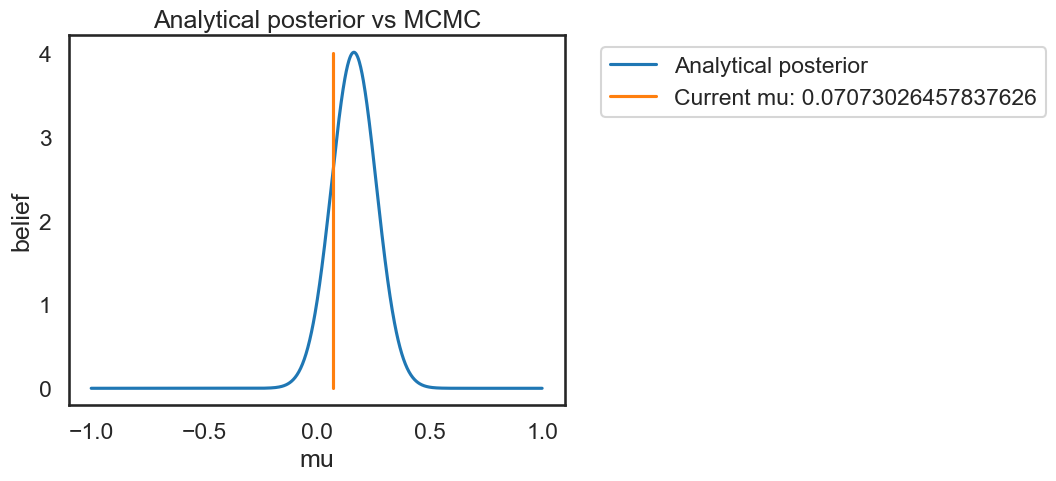

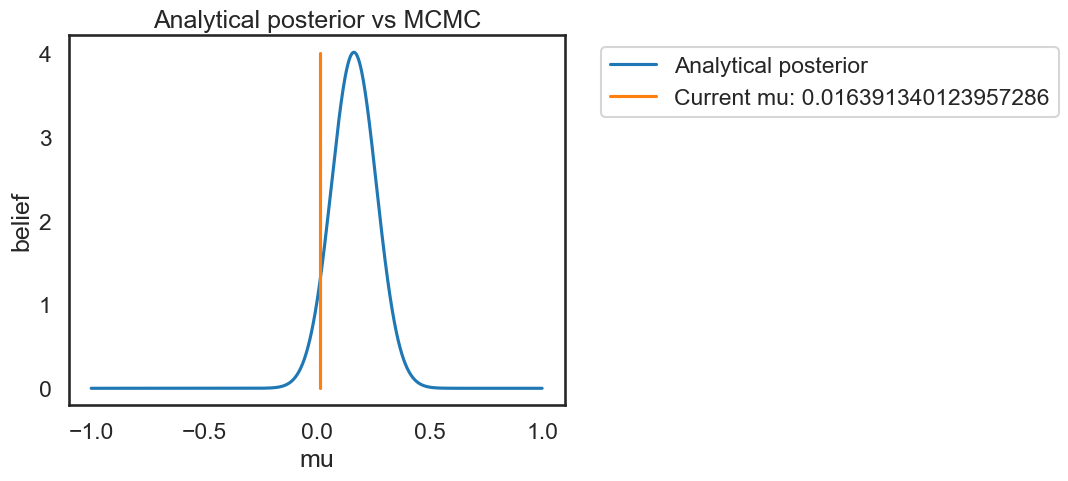

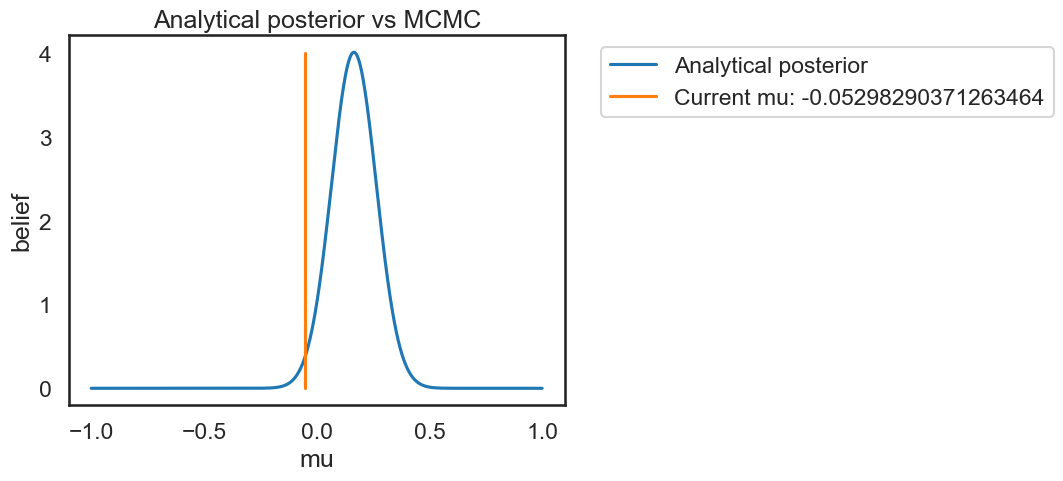

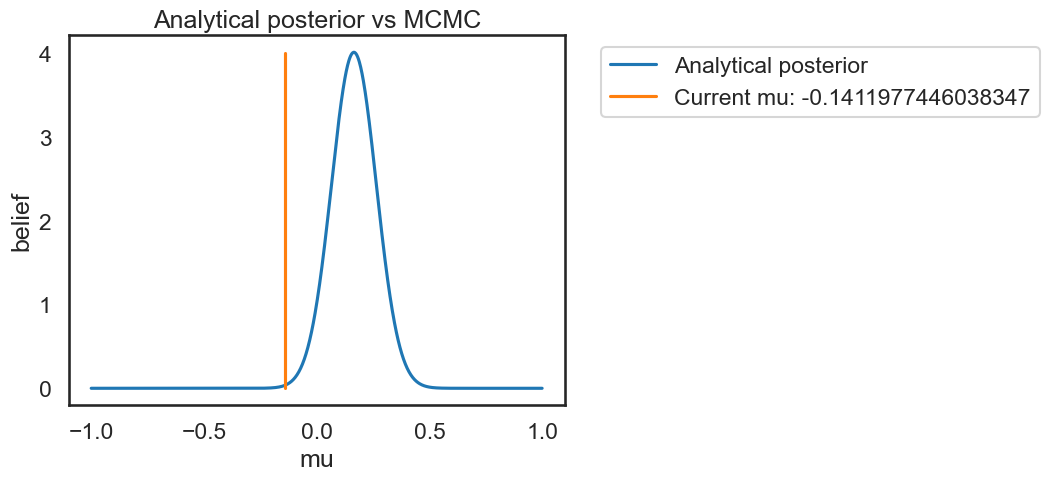

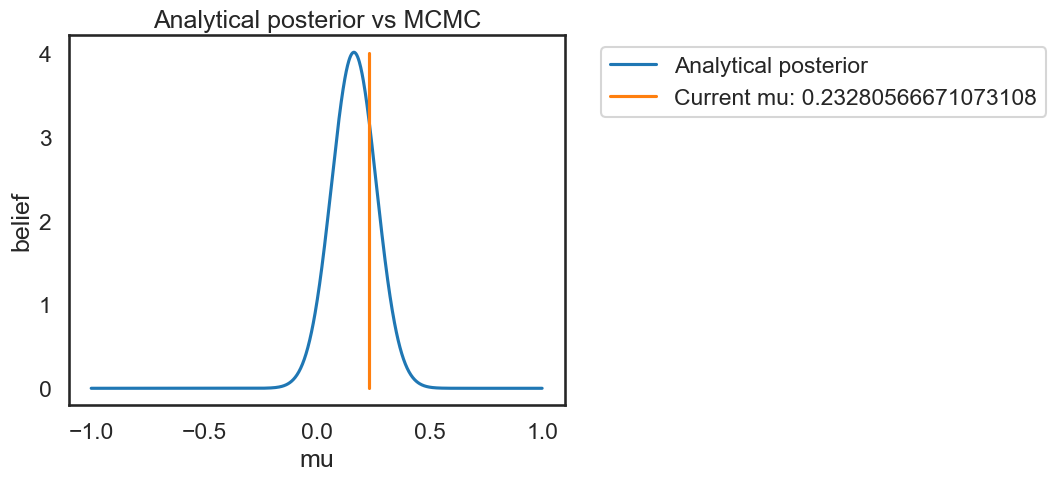

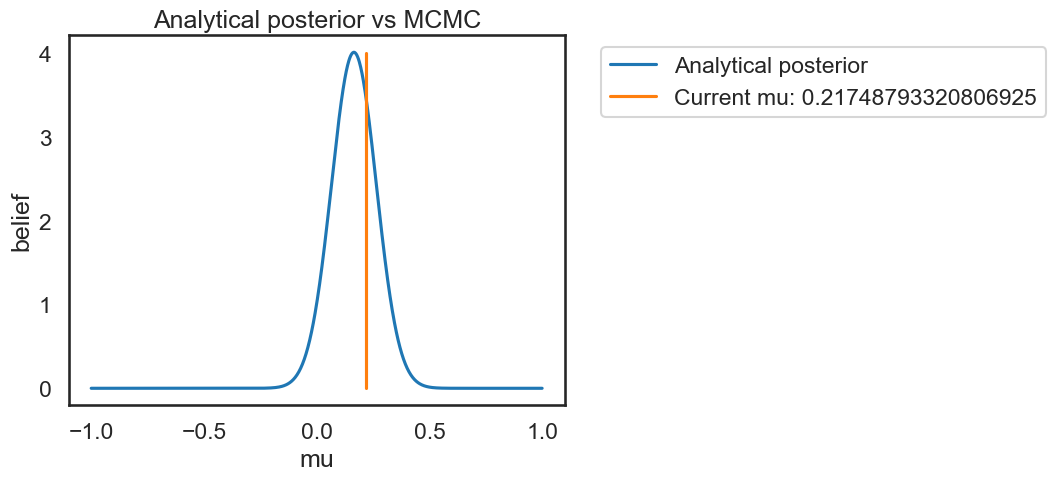

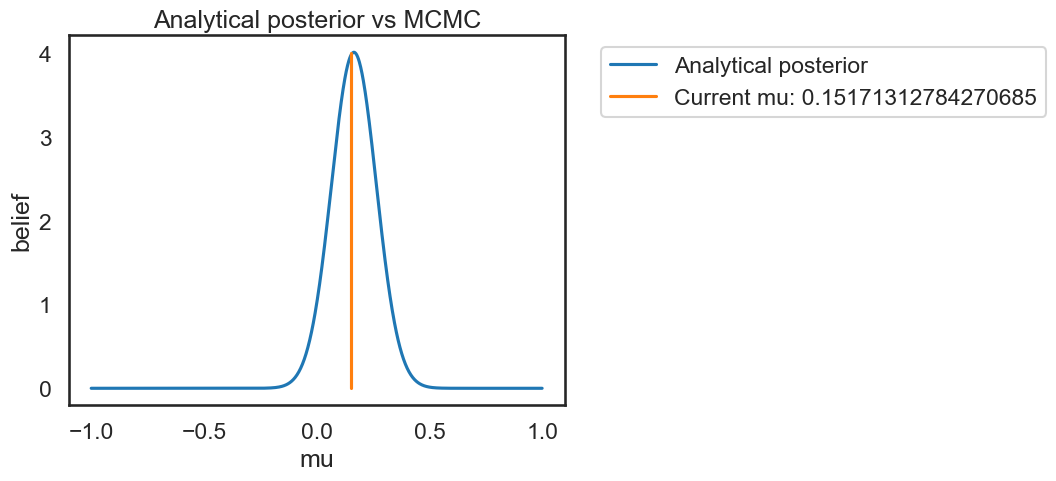

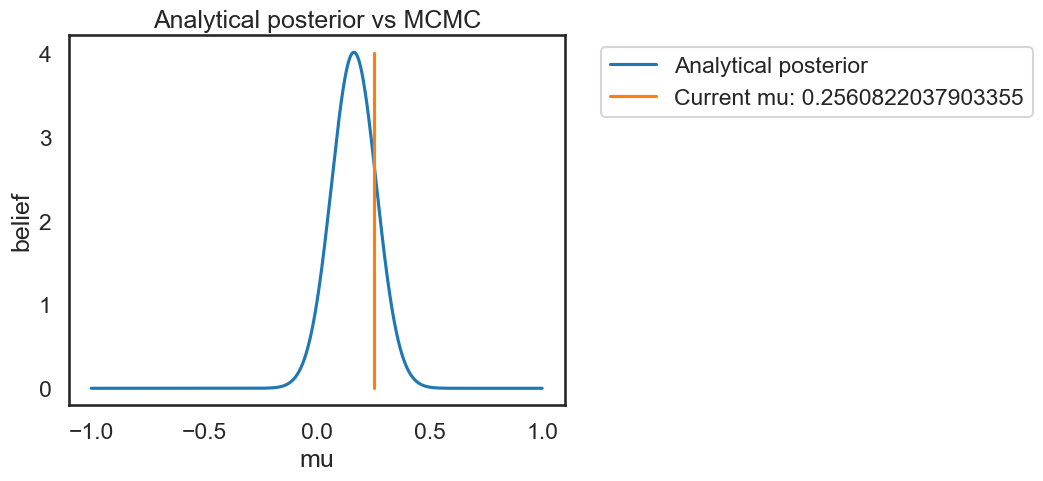

In [5]:
def mcmc_metropolis(data, iteration, mu_initial, proposal_sd, mu_prior_mu, mu_prior_sd, likelihood_sd):

    # We will start by initializing our mu value and adding it to the list of posteriors as a starting point
    mu_current = mu_initial
    posterior = [mu_current]

    #For given number of iterations, we will sample a posterior and accept it if it meets the criteria
    for i in range(iteration):
        mu_proposed = st.norm(mu_current, proposal_sd).rvs()

        # We compute the likelihood value for our current mu and proposed mu
        likelihood_current = st.norm(mu_current, likelihood_sd).pdf(data).prod()
        likelihood_proposed = st.norm(mu_proposed, likelihood_sd).pdf(data).prod()

        # we compute the prior probability of current and proposed mu
        mu_probability_current = st.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        mu_probability_propsed = st.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposed)

        # We calculate the nominator of the Bayes formula for both current and proposed values
        nominator_current = likelihood_current * mu_probability_current
        nominator_proposed = likelihood_proposed * mu_probability_propsed

        # We calculate the acceptance probability by dividing the two probabilities. This also helps us avoid denominator integration
        accept_probability = min((nominator_proposed / nominator_current), 1)

        accept =  np.random.rand() < accept_probability

        # If we accept the proposal, we update the current mu value and add it to the list of posteriors
        if accept:
            mu_current = mu_proposed

        posterior.append(mu_current)
    
    return posterior

# Running the sampler
posterior_list = mcmc_metropolis(data=data, iteration=25, mu_initial=np.random.randn(), proposal_sd=0.5, mu_prior_mu=0, mu_prior_sd=1, likelihood_sd=1)
#print(posterior_list)

#List of unique mu values
unique_posterior_list = list(dict.fromkeys(posterior_list))
print(unique_posterior_list)

#X values to draw the distribution on
x = np.linspace(-1, 1, 1000)

#Analytical posterior graph
posterior_calc = gaussian_conjugate_posterior(data, x, 0, 1)

#For each unique accepted mu proposal, plotting a graph of distribution in the range of x values
for i in range(len(unique_posterior_list)):
    plt.plot(x, posterior_calc, label = "Analytical posterior")
    plt.plot([unique_posterior_list[i]] * 100, np.linspace(0, 4, 100), label = "Current mu: " + str(unique_posterior_list[i]))
    plt.xlabel("mu")
    plt.ylabel("belief")
    plt.title("Analytical posterior vs MCMC")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()



0.1652280460961789
0.009900990099009901


/var/folders/hk/_g475vss66n_f_6s0_3sdxk40000gn/T/ipykernel_5382/3508136946.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(posterior[500:], ax=ax, label='estimated posterior')


Text(0.5, 1.0, 'Analytical posterior vs Estimated posterior')

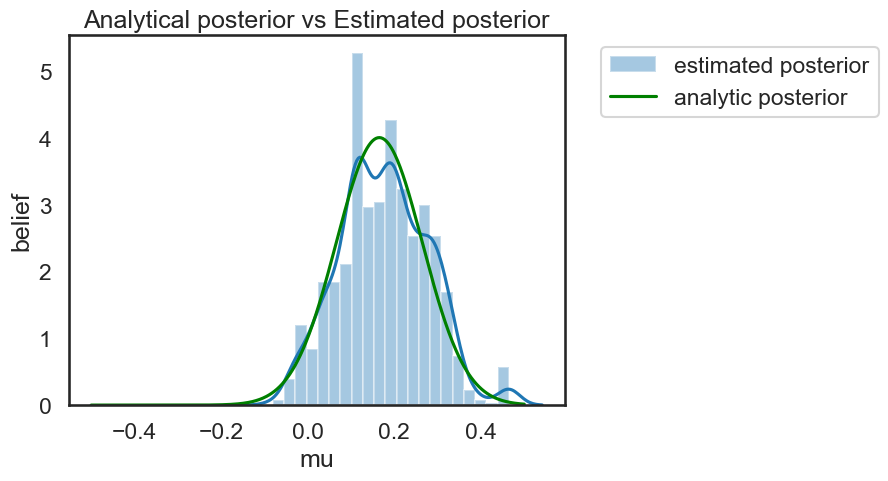

In [6]:
posterior = mcmc_metropolis(data=data, iteration=1500, mu_initial=np.random.randn(), proposal_sd=0.5, mu_prior_mu=0, mu_prior_sd=1, likelihood_sd=1)

fig, ax = plt.subplots()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = gaussian_conjugate_posterior(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Analytical posterior vs Estimated posterior")
